# 1. Loading the data

### We are going to analyze single-cell RNA-seq data that are available at the GEO database : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE121521
### Sample is here : https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM3438654
### Publication is here : https://www.nature.com/articles/s41564-019-0633-0

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [ ]:
results_file = 'write/resultfile'

In [ ]:
adata = sc.read_10x_mtx('GSM3438654', var_names='gene_symbols', cache=True)

## Preprocessing

### Basic filtering

In [ ]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
adata

### Genes

In [ ]:
adata.var

In [ ]:
adata.var_names

## Observations

In [ ]:
adata.obs.head(10)

## Unstructured data

It will be empty for now

In [ ]:
adata.uns

## Matrix

In [ ]:
adata.X

### Show those genes that yield the highest fraction of counts in each single cell, across all cells

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# 2. Visualize and filter out poor-quality cells

In single cell analysis, mitochondrial DNA is highly detected in dying cells. We want to remove those bad quality cells.

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

In [ ]:
adata.obs

In [ ]:
adata.var

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
adata = adata[adata.obs.n_genes_by_counts > 900, :].copy()
adata = adata[adata.obs.pct_counts_mt < 4.5, :].copy()

adata

In [ ]:
import scanpy as sc
import seaborn as sns

sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
)

# 3. Normalize and scale the data

In [ ]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Now our data are normalized

# 4. Identification of biologicaly variable genes

In [ ]:
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False)

In [ ]:
adata.var['highly_variable'].value_counts()

# 5. PCA

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pl.pca(adata, color='Cd3d')

### Cd3d is a T-cell surface marker and here we can see that it is expressed only in a particular cluster. We have to perform non-linear dimensionality reduction to obtain more informations.

# 6. Compute neghborhood graph and embedd it using UMAP visualization (non-linear dimensionality reduction)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

# 7. Cells clustering

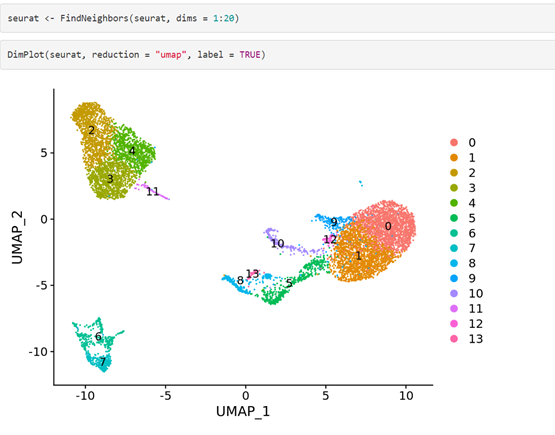

### Here is our clustering with Rstudio, we are going to have exact similar clustering, expet it's symetrically inversed but same number of cluster with the default resolution.

In [ ]:
sc.tl.louvain(adata, resolution=1)
sc.pl.umap(adata, color='louvain')

### Resolution is decrease to 1.0 in order to have 12 clusters, which is enough and consistent with the publication.

# 8. Visualizing gene expression in clusters

In [ ]:
sc.pl.umap(adata, color=["Cd3d", "Cd3g", "Blk", "Spib", "Ccr5", "Cd14"])

### We can see that T cells markers Cd3d and Cd3g are located in the cluster 6.
### B cells markers Blk and Spib are located in the clusters 1, 2, 3 and 4 that can be considered as a super cluster here.
### Macrophages markers Ccr5 and Cd14 are in the clusters at the opposite side of the graph.

In [ ]:
sc.pl.umap(adata, color=["Ciita", "Tap1", "H2-Ab1", "Cd163", "Cd68", "Cd84"])

### Tap1, Ciita and H2Ab1 are caracteristic markers of MHC class II. We can see that these markers are low expressed especially in macrophage's clusters (markers Cd163, Cd68 and Cd84) and also in T cells cluster. Naive T cells are not related to MHC class II. These observations seems to be a big point of the paper.

# 9. Running DGE tests to find cluster biomarkers

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)

In [ ]:
sc.pl.umap(adata, color=["Cebpb", "Ebf1", "Ms4a4b"])

### CEBPB is critical for normal macrophage functionning, it expression cluster is consistent with our previous result.

### EBF1 controls the expression of key proteins required for B cell differentiation, signal transduction and function, this supercluster is essentially composed of B cells.

### MS4A4B Is a GITR-associated membrane adapter, expressed by T Cells which are in cluster 6.

### With Rstudio we can change things with different argument and parameters but the conclusion about the genes expression are the same

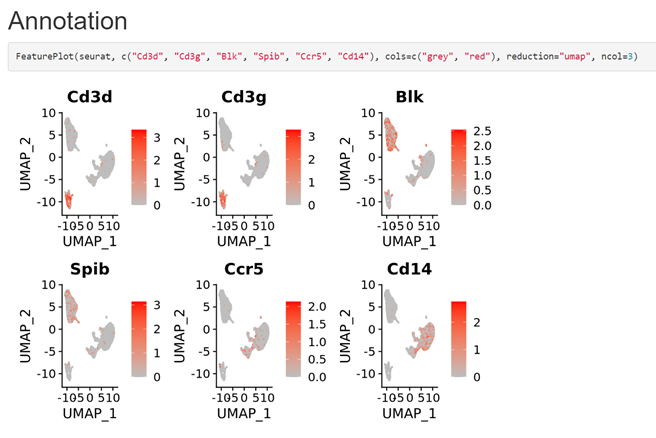

### Violin plot obtained with Rstudio, we can do that we scanpy also but we are going to show some other type of plot with it.

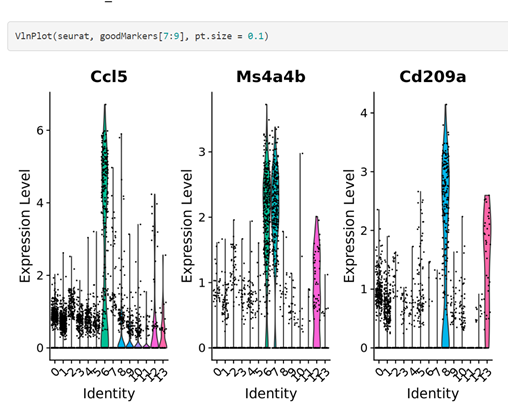

## Another clustering and change size

In [ ]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
    sc.tl.leiden(adata, key_added='clusters', resolution=0.7)
    sc.pl.umap(adata, color='leiden', s=20)

## Extract embeddings

In [ ]:
adata.obsm

In [ ]:
df = pd.DataFrame(adata.obsm['X_pca'])

In [ ]:
df

In [ ]:
adata.X

In [ ]:
adata.var

In [ ]:
adata.obs

In [ ]:
adata.uns

### We are going to show 2 more way to visualize our expression data within scanpy. First we can use a dotplot. This type of plot summarizes two types of information: the color represents the mean expression within each of the categories (in this case in each cluster) and the dot size indicates the fraction of cells in the categories expressing a gene.

In [ ]:
marker_genes_dict = {
    'Macrophage': ['Cebpb', 'Cd14'],
    'T-cell': ['Cd3d', 'Ms4a4b'],
    'B-cell': ['Ebf1', 'Spib'],
}

In [ ]:
sc.pl.dotplot(adata, marker_genes_dict, 'clusters', dendrogram=True)

In [ ]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '7': 'Macrophage',
     '2': 'B-cell',
     '4': 'T-cell',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell type'] = adata.obs['clusters'].map(cluster2annotation).astype('category')

In [ ]:
sc.pl.dotplot(adata, marker_genes_dict, 'cell type', dendrogram=True)

In [ ]:
sc.pl.umap(adata, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

### A good way to vizualize expression data is to do a heatmap

In [ ]:
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='clusters', cmap='viridis', dendrogram=True)

### This various visual reprensation seems to confirm our observations and the paper results, espcially about T naive cells indepedent and MHC class 2 are low expressed macrophages clusters. To confirm that and build more robust plot we can add other markers and make conclusions about their differential expressions.

# Trajectory inference

In [ ]:
import matplotlib.pyplot as pl
from matplotlib import rcParams

In [ ]:
adata.X = adata.X.astype('float64')

In [ ]:
sc.pp.recipe_zheng17(adata)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

## Denoising 

In [ ]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

In [ ]:
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.draw_graph(adata, color='clusters', legend_loc='on data')

In [ ]:
sc.tl.louvain(adata, resolution=1.0)

In [ ]:
sc.tl.paga(adata, groups='louvain')

In [ ]:
sc.pl.paga(adata, color=['louvain', 'Cebpb', 'Cd3d', 'Ebf1'])

In [ ]:
sc.pl.paga(adata, color=['louvain', 'Ms4a4b', 'Spib'])

In [ ]:
adata.obs['louvain'].cat.categories

In [ ]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [ ]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40']

### Let’s use the annotated clusters for PAGA.

In [ ]:
sc.tl.paga(adata, groups='louvain_anno')

In [ ]:
sc.pl.paga(adata, threshold=0.03, show=False)

## Recomputing the embedding using PAGA-initialization

In [ ]:
sc.tl.draw_graph(adata, init_pos='paga')

In [ ]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Cebpb', 'Cd3d', 'Ebf1'], legend_loc='on data')

In [ ]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_28[i], s=200)
pl.show()

In [ ]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_28)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [ ]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [ ]:
adata.uns['louvain_anno_colors'] = new_colors

In [ ]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '0')[0]

In [ ]:
sc.tl.dpt(adata)

In [ ]:
gene_names = ['Cebpb', 'Cd14',
              'Cd3d', 'Ms4a4b',
              'Ebf1', 'Spib']

In [ ]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

In [ ]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [ ]:
paths = [('macrophages', [12, 32, 34, 25]),
         ('T-cells', [22, 23, 24, 30]),
         ('B-cells', [26, 9, 25, 12, 9])]

In [ ]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [ ]:
adata.obs['clusters'] = adata.obs['louvain_anno']

In [ ]:
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [ ]:
!mkdir write

In [ ]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/res.pdf')
pl.show()

### We can see that this is just another way to cluster and visiualize our gene expression data